In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib as plt
import numpy as np

## Import Data

In [2]:
window_data = pd.read_csv("data/first_31dbs_counters_string_time_data.csv")
immersive_data = pd.read_csv("data/first_31dbs_isImmersive_data.csv")

In [3]:
window_data.shape

(4815, 2)

In [4]:
window_data.head()

,time,window
0,2021-11-12 18:17:47.026,cmd.exe
1,2021-11-12 18:17:54.031,SearchApp.exe
2,2021-11-12 18:18:16.046,cmd.exe
3,2021-11-12 18:18:21.052,SearchApp.exe
4,2021-11-12 18:18:50.083,notepad++.exe


In [5]:
immersive_data.head()

,time,is_immersive
0,2021-11-12 18:17:47.026,0
1,2021-11-12 18:17:54.031,1
2,2021-11-12 18:18:16.046,0
3,2021-11-12 18:18:21.052,1
4,2021-11-12 18:18:50.083,0


In [6]:
#joined tables on the time according to rows in the window data
data = window_data.merge(immersive_data, on = "time", how = 'left')

### NaN Data

In [7]:
#There are clearly Nan values and 5 occurences of a very strange number
data.is_immersive.value_counts(dropna = False)

 0.000000e+00    2851
 1.000000e+00    1428
 NaN              531
-9.223372e+18       5
Name: is_immersive, dtype: int64

In [8]:
# 531 rows of NaN values
nan_indeces = pd.isnull(data).any(1).nonzero()[0]
nan_data = data.loc[nan_indeces]
nan_data.head()

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


,time,window,is_immersive
99,2021-11-12 19:06:33.601,EXCEL.EXE,NaN
238,2021-11-14 23:34:22.110,chrome.exe,NaN
320,2021-11-15 07:44:09.661,WINWORD.EXE,NaN
2074,2021-11-26 04:22:00.528,WINWORD.EXE,NaN
2108,2021-11-28 19:51:42.041,cmd.exe,NaN


## Data Cleaning

In [9]:
#Change first time col to datetime obj
data['time'] = pd.to_datetime(data['time'])

In [10]:
#Add weekdays to df
weekdays = ['Mon','Teu','Wed','Thur','Fri','Sat','Sun']
def get_weekday(date):
    return date.weekday()

data['WEEKDAY'] = data['time'].apply(get_weekday)
data.head(1)

,time,window,is_immersive,WEEKDAY
0,2021-11-12 18:17:47.026,cmd.exe,0.0,4


## EDA

Text(0.5, 1.0, 'Number of Window Changes Per Day of the Week')

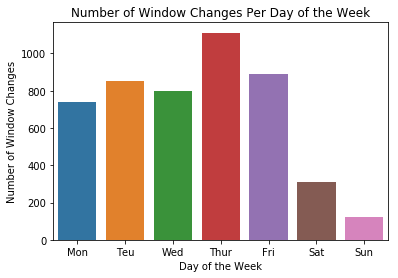

In [11]:
num_apps_opened_per_weekday = data.groupby('WEEKDAY')['window'].count()
g = sns.barplot(y = num_apps_opened_per_weekday.values, x = num_apps_opened_per_weekday.index)
g.set_xticklabels(['Mon','Teu','Wed','Thur','Fri','Sat','Sun'])
g.set_ylabel('Number of Window Changes')
g.set_xlabel('Day of the Week')
g.set_title('Number of Window Changes Per Day of the Week')

In [12]:
#Get unique window counts
num_changes_per_unique_windows = data.groupby('window')['WEEKDAY'].count().sort_values(ascending = False)
top_10_num_unique_windows = num_changes_per_unique_windows[:10]
top_5_num_unique_windows = num_changes_per_unique_windows[:5]

top_10_num_unique_windows

window
chrome.exe       1487
explorer.exe      831
Teams.exe         301
Discord.exe       285
devenv.exe        252
Zoom.exe          207
LockApp.exe       188
HxOutlook.exe     180
msedge.exe        154
WINWORD.EXE       150
Name: WEEKDAY, dtype: int64

Text(0.5, 1.0, 'Number of Window Changes Per Window')

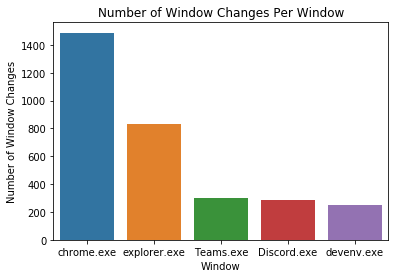

In [13]:
#Top 5 apps that have the most amount of "switch to occurences"
g = sns.barplot(y = top_5_num_unique_windows.values, x = top_5_num_unique_windows.index)
# g.set_xticklabels(['Mon','Teu','Wed','Thur','Fri','Sun'])
g.set_ylabel('Number of Window Changes')
g.set_xlabel('Window')
g.set_title('Number of Window Changes Per Window')

In [14]:
#Extract time spent within each app
data['tvalue'] = data.time
data['delta'] = (data['tvalue']- data['tvalue'].shift()).fillna(0)

#convert days spent on window to minutes spent on window
def convert_minutes(time):
    return round(float((time.total_seconds()/60)), 2)

data['MINS_SPENT'] = data.delta.apply(convert_minutes)
new_mins = list(data.MINS_SPENT)[1:]
new_mins.append(0)
data['MINS_SPENT'] = new_mins

data = data.drop(['tvalue','delta'],axis = 1)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
data.head(1)

,time,window,is_immersive,WEEKDAY,MINS_SPENT
0,2021-11-12 18:17:47.026,cmd.exe,0.0,4,0.12


#### Since Chrome.exe is the most visited app, let's dive deeper into it

In [16]:
#Get dataframe of only chrome.exe rows
chrome_df = data[data.window == 'chrome.exe']

In [17]:
copy = chrome_df.copy()

#new chrome_df with no outliers (time spent in sleep mode)
copy_no_outliers = copy[copy['MINS_SPENT'] <= 400]

#get total mins spent on chrome per weekday without the outliers
mins_per_weekday_chrome = copy_no_outliers.groupby('WEEKDAY')['MINS_SPENT'].sum()

In [18]:
chrome_df.sort_values(by = 'MINS_SPENT', ascending = False).head()

,time,window,is_immersive,WEEKDAY,MINS_SPENT
3626,2021-12-15 18:35:11.551,chrome.exe,0.0,2,1639.77
2044,2021-11-25 06:15:21.702,chrome.exe,0.0,3,1258.17
2220,2021-11-29 06:35:43.407,chrome.exe,NaN,0,898.94
2240,2021-11-30 04:59:49.805,chrome.exe,NaN,1,889.52
1688,2021-11-23 08:42:37.939,chrome.exe,0.0,1,747.70


In [19]:
copy_no_outliers.sort_values(by = 'MINS_SPENT', ascending = False).head()

,time,window,is_immersive,WEEKDAY,MINS_SPENT
222,2021-11-13 02:06:13.157,chrome.exe,0.0,5,357.11
3839,2021-12-22 22:45:51.835,chrome.exe,0.0,2,325.89
1341,2021-11-19 02:13:57.068,chrome.exe,0.0,4,314.68
157,2021-11-12 19:53:35.950,chrome.exe,0.0,4,287.90
3872,2021-12-23 22:11:27.107,chrome.exe,NaN,3,236.59


In [20]:
mins_per_weekday_dict = dict(mins_per_weekday_chrome)

mins = []
for i in range(len(chrome_df)):
    mins.append(mins_per_weekday_dict[chrome_df.iloc[i].WEEKDAY])

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Minutes Spent on Chrome')

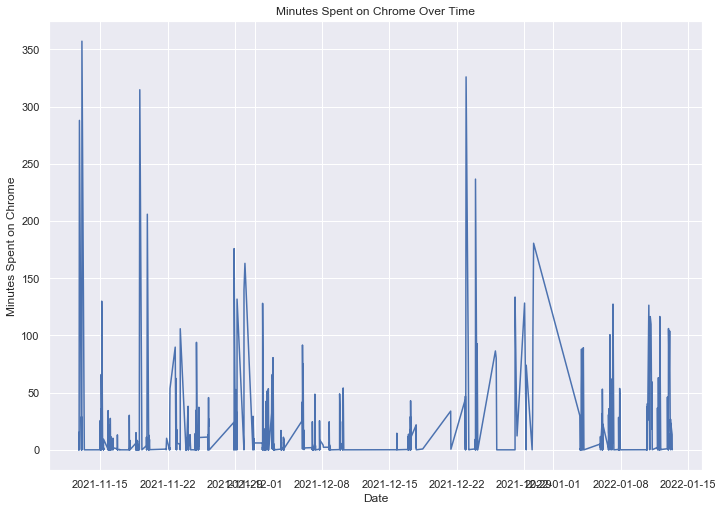

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plot1 = sns.lineplot(x = 'time', y = 'MINS_SPENT', data = copy_no_outliers)
plot1.set_title('Minutes Spent on Chrome Over Time')
plot1.set_xlabel('Date')
plot1.set_ylabel('Minutes Spent on Chrome')

### Windows with the most time spent on them

In [22]:
data_no_outliers = data[data['MINS_SPENT'] <= 400]
sum_mins_per_window = data_no_outliers.groupby('window')['MINS_SPENT'].sum()
mins_per_window = sum_mins_per_window.sort_values(ascending = False)[:5]

Text(0.5, 1.0, 'Top 5 Windows With Greatest Number of Mins Spent')

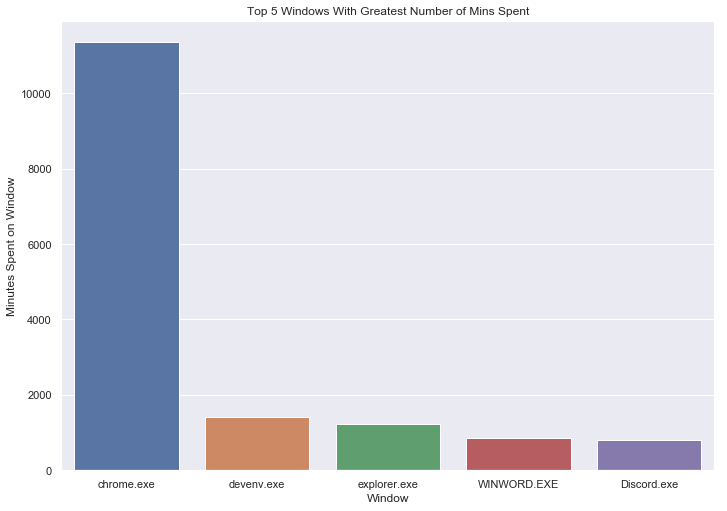

In [23]:
g = sns.barplot(x = mins_per_window.index, y = mins_per_window.values)
g.set_ylabel('Minutes Spent on Window')
g.set_xlabel('Window')
g.set_title('Top 5 Windows With Greatest Number of Mins Spent')

Text(0.5, 1.0, 'Mins Per Weekday Spent on Chrome Over a 5 Day Span')

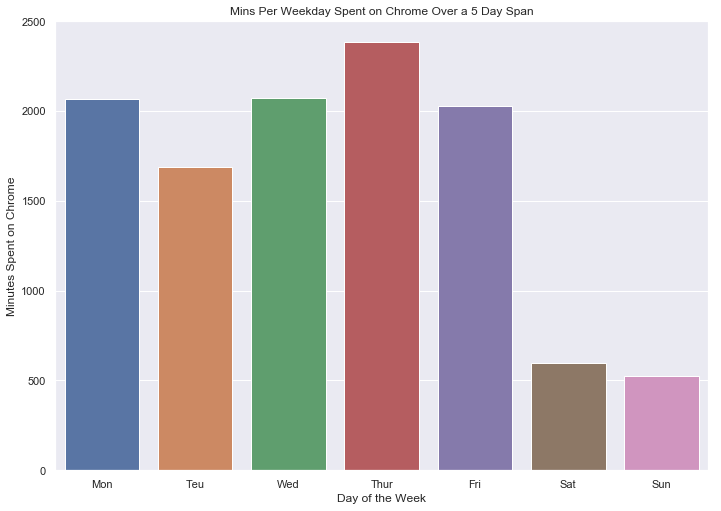

In [24]:
g = sns.barplot(x = mins_per_weekday_chrome.index, y = mins_per_weekday_chrome.values)
g.set_xticklabels(['Mon','Teu','Wed','Thur','Fri','Sat','Sun'])
g.set_ylabel('Minutes Spent on Chrome')
g.set_xlabel('Day of the Week')
g.set_title('Mins Per Weekday Spent on Chrome Over a 5 Day Span')

### Immersive Data

We know that chrome is not an app you can find in the Window's store. These also pertain to Windows specific apps such as ethernet explorer or even apps found on Windows OS such as the shell. So lets dive into the apps that CAN be found in the Window's store, aka the apps that are immersive!

In [25]:
# A look at which apps that are found in the window's store
immersive = data[data.is_immersive == 1]
immersive.window.value_counts()

explorer.exe                      745
HxOutlook.exe                     168
LockApp.exe                       163
SearchApp.exe                     116
ApplicationFrameHost.exe           58
ShellExperienceHost.exe            56
SystemSettings.exe                 33
Microsoft.AAD.BrokerPlugin.exe     23
ScreenClippingHost.exe             21
StartMenuExperienceHost.exe        19
PickerHost.exe                      9
SystemSettingsAdminFlows.exe        5
WindowsCamera.exe                   4
Taskmgr.exe                         4
OpenWith.exe                        2
HxCalendarAppImm.exe                1
Microsoft.Photos.exe                1
Name: window, dtype: int64

In [26]:
#remove idle times 
immersive_no_outliers = immersive[immersive.MINS_SPENT <= 400]

In [27]:
immersive_no_outliers.groupby('window')['MINS_SPENT'].sum().sort_values(ascending = False)

window
explorer.exe                      1178.66
HxOutlook.exe                      561.11
StartMenuExperienceHost.exe        235.68
LockApp.exe                        209.56
ApplicationFrameHost.exe            81.05
ShellExperienceHost.exe             20.87
SystemSettings.exe                  10.94
Microsoft.AAD.BrokerPlugin.exe       8.71
SearchApp.exe                        8.67
WindowsCamera.exe                    3.56
ScreenClippingHost.exe               2.28
PickerHost.exe                       1.52
Taskmgr.exe                          0.54
SystemSettingsAdminFlows.exe         0.11
OpenWith.exe                         0.08
HxCalendarAppImm.exe                 0.03
Microsoft.Photos.exe                 0.02
Name: MINS_SPENT, dtype: float64

We can see that explorer exe takes up the bulk of time spent on Windows apps. This is expected since every the windows file explorer is included within explorer.exe. Additionally, time I click on chrome or spotify or something on my task bar, it logs explorer.exe. 

## Probabilities

In [28]:
def conditional_probs(df, col_name, val_name):
    val_count = df[col_name].value_counts()[val_name]
    other_val_count = df[col_name].value_counts().sum() - val_count
    return val_count / other_val_count

In [29]:
conditional_probs_dict = {}

for val in data['window'].value_counts().index: #for each window in data
    conditional_probs_dict[val] = conditional_probs(data, 'window', val)
conditional_probs_df = pd.DataFrame.from_dict(conditional_probs_dict, orient='index')
conditional_probs_df.columns = ['conditional_prob']
conditional_probs_df.sort_values('conditional_prob', ascending=False)
conditional_probs_df.head()

,conditional_prob
chrome.exe,0.446815
explorer.exe,0.208584
Teams.exe,0.066681
Discord.exe,0.062914
devenv.exe,0.055227


In [30]:
data.head()

,time,window,is_immersive,WEEKDAY,MINS_SPENT
0,2021-11-12 18:17:47.026,cmd.exe,0.0,4,0.12
1,2021-11-12 18:17:54.031,SearchApp.exe,1.0,4,0.37
2,2021-11-12 18:18:16.046,cmd.exe,0.0,4,0.08
3,2021-11-12 18:18:21.052,SearchApp.exe,1.0,4,0.48
4,2021-11-12 18:18:50.083,notepad++.exe,0.0,4,0.02
